# This notebook is for the manual tuning of using random search

## Imports

In [53]:
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, cross_validate, KFold
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

## Classifiers

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

## Functions for storing the data

In [54]:
def pickle_dump(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)

def pickle_load(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

## Running nested cross validation
This is a variation of the code used on sklearn's website: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

In [59]:
# Load the dataset
fl = "winequality-white.csv"
table = pd.read_csv(fl, delimiter = ";", header='infer')

# We are aiming to predict quality with the features chosen from the correlations
features = ["alcohol", "density", "chlorides", "volatile acidity", "total sulfur dioxide", "fixed acidity", "pH"]
X = table[features]
y = table.quality

# Set up possible values of parameters to optimize over
params_dt = { 'criterion' : ['gini', 'entropy'],
              'min_samples_leaf': np.linspace(1, 20, num=15, dtype=int),
              'min_samples_split': np.linspace(2, 20, num=15, dtype=int) }

params_gb = {'learning_rate' : np.linspace(0.01, 1.0, num=15), 
              'max_leaf_nodes' : np.linspace(3, 2047, num=15, dtype=int), 
              'min_samples_leaf' : np.linspace(1, 200, num=15, dtype=int),
              'n_iter_no_change' : np.linspace(1, 20, num=15, dtype=int),
              'validation_fraction' : np.linspace(0.01, 0.4, num=15)}

params_knn = {'n_neighbors' : np.linspace(1,100, num=15, dtype=int),
              'p' : [1,2],
              'weights' : ['uniform', 'distance']}

params_log = {'C' : np.linspace(0.03125, 5, num=15), ## Restricted the upper bound from 32768 to 5, to mimic autosklearn and preserve runtime
              'tol' : np.linspace(0.00001, 0.1, num=15),
              'penalty' : ['l1', 'l2']}

params_rf = {'bootstrap' : [True, False],
             'criterion' : ['gini', 'entropy'],
             'min_samples_leaf': np.linspace(1, 20, num=15, dtype=int), 
             'min_samples_split': np.linspace(2, 20, num=15, dtype=int) }

# Here are our classifiers
classifiers = [ DecisionTreeClassifier(random_state= 5),
                GradientBoostingClassifier(random_state= 5),
                KNeighborsClassifier(),
                LogisticRegression(random_state= 5, solver='liblinear'),
                RandomForestClassifier(random_state= 5)]

param_grids = [params_dt, params_gb, params_knn, params_log, params_rf]

classifier_names = ['decision_tree', 'gradient_boosting', 'k_nearest_neighbors', 'logistic_regression', 'random_forest']

# Loop for each trial
all_data_accuracy = {}
all_data_hyperparams = {}

for j, classifier in enumerate(classifiers):
    param_grid = param_grids[j]
    classifier_name = classifier_names[j]

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=5)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=5)

    # Nested CV with parameter optimization
    clf = RandomizedSearchCV(classifier, param_grid, cv=inner_cv, scoring= 'accuracy', random_state= 5)
    cv_result = cross_validate(clf, X=X, y=y, cv=outer_cv, return_estimator=True)
    
    all_data_accuracy[classifier_name] =  cv_result['test_score']

    hyperparams_runs = [cv_result['estimator'][i].best_params_ for i in range(5)]
    all_data_hyperparams[classifier_name] = hyperparams_runs


    

/home/stonestate5/Desktop/GraduateClassWork/PracticalML/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/stonestate5/Desktop/GraduateClassWork/PracticalML/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stonestate5/Desktop/GraduateClassWork/PracticalML/.venv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 430, in fit
    train_test_split(X, y, sample_weight,
  File "/home/stonestate5/Desktop/GraduateClassWork/PracticalML/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py", line 2197, in train_test_split
    train, test = next(cv.split(X=arrays[0], y=stratify))
  File "/home/stonestate5/Desktop/GraduateClassWork/PracticalML/.venv/lib/

## Store our results

In [60]:
pickle_dump(all_data_accuracy, './random_search_results/accuracy.pkl')
pickle_dump(all_data_hyperparams, './random_search_results/hyperparameters.pkl')

## Display our results

In [61]:
pickle_load('./random_search_results/accuracy.pkl')

{'decision_tree': array([0.55816327, 0.52244898, 0.54387755, 0.52706844, 0.52911134]),
 'gradient_boosting': array([0.56836735, 0.56632653, 0.58061224, 0.52604699, 0.51276813]),
 'k_nearest_neighbors': array([0.65408163, 0.63163265, 0.61632653, 0.62002043, 0.62717058]),
 'logistic_regression': array([0.53673469, 0.50306122, 0.52755102, 0.50663943, 0.52093973]),
 'random_forest': array([0.68061224, 0.67857143, 0.69489796, 0.64862104, 0.65270684])}

In [62]:
randomized_search_acc = pickle_load('./random_search_results/accuracy.pkl')
pd.DataFrame.from_dict(randomized_search_acc)

,decision_tree,gradient_boosting,k_nearest_neighbors,logistic_regression,random_forest
0,0.558163,0.568367,0.654082,0.536735,0.680612
1,0.522449,0.566327,0.631633,0.503061,0.678571
2,0.543878,0.580612,0.616327,0.527551,0.694898
3,0.527068,0.526047,0.620020,0.506639,0.648621
4,0.529111,0.512768,0.627171,0.520940,0.652707


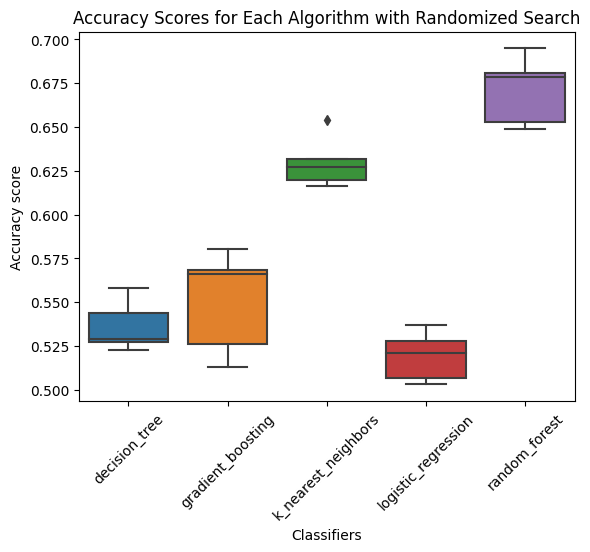

In [73]:
def boxplot_randomized_search():
    randomized_search_acc = pickle_load('./random_search_results/accuracy.pkl')
    table = pd.DataFrame.from_dict(randomized_search_acc)
    
    box = sns.boxplot(table)
    plt.xticks(rotation=45)
    plt.xlabel('Classifiers')
    plt.ylabel('Accuracy score')
    plt.title('Accuracy Scores for Each Algorithm with Randomized Search')
    plt.savefig('./figures/box_plot_randomized_search')
boxplot_randomized_search()

In [82]:
def make_accuracy_stats():
    cv_results_accuracy = pickle_load('./random_search_results/accuracy.pkl')
    tab = {}
    for classifier in cv_results_accuracy.keys():
        class_stats = {}
        class_stats['Mean Accuracy'] = np.mean(cv_results_accuracy[classifier])
        class_stats['Standard Deviation'] = np.std(cv_results_accuracy[classifier])
        tab[classifier] = class_stats
    return pd.DataFrame.from_dict(tab).T
make_accuracy_stats()

,Mean Accuracy,Standard Deviation
decision_tree,0.536134,0.013146
gradient_boosting,0.550824,0.026448
k_nearest_neighbors,0.629846,0.013244
logistic_regression,0.518985,0.012635
random_forest,0.671082,0.017642


## We see that Random Forest performs the best, let's look at the hyperparameters:

In [78]:
cv_results_hyperparams = pickle_load('./random_search_results/hyperparameters.pkl')
for i in range(5):
    print(cv_results_hyperparams['random_forest'][i])

{'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini', 'bootstrap': False}
{'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini', 'bootstrap': False}
{'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini', 'bootstrap': False}
{'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini', 'bootstrap': False}
{'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini', 'bootstrap': False}


For all tests, we see that the best hyperparameter settings are the same for each outer cross validation fold.

So, our best hyperparameter settings for Random Forest is:
- `min_samples_split` : 7
- `min_samples_leaf` : 1
- `criterion` : 'gini'
- `bootstrap` : False
